# MNIST Digit Classification - FCN

In [1]:
from __future__ import division, print_function
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

LOG_DIR = os.path.join(DATA_DIR, "tf-mnist-fcn-logs")
MODEL_FILE = os.path.join(DATA_DIR, "tf-mnist-fcn")

IMG_SIZE = 28
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 10

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xdata.append([float(x) / 255. for x in cols[1:]])
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    y = np.array(ydata)
    X = np.array(xdata)
    return X, y

Xtrain, ytrain = parse_file(TRAIN_FILE)
Xtest, ytest = parse_file(TEST_FILE)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 784) (60000,) (10000, 784) (10000,)


In [4]:
def datagen(X, y, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES):
    ohe = OneHotEncoder(n_values=num_classes)
    while True:
        shuffled_indices = np.random.permutation(np.arange(len(y)))
        num_batches = len(y) // batch_size
        for bid in range(num_batches):
            batch_indices = shuffled_indices[bid*batch_size:(bid+1)*batch_size]
            Xbatch = np.zeros((batch_size, X.shape[1]))
            Ybatch = np.zeros((batch_size, num_classes))
            for i in range(batch_size):
                Xbatch[i] = X[batch_indices[i]]
                Ybatch[i] = ohe.fit_transform(y[batch_indices[i]]).todense()
            yield Xbatch, Ybatch

self_test_gen = datagen(Xtrain, ytrain)
Xbatch, Ybatch = self_test_gen.next()
print(Xbatch.shape, Ybatch.shape)

(128, 784) (128, 10)


## Define Network

In [5]:
X = tf.placeholder(tf.float32, [BATCH_SIZE, IMG_SIZE*IMG_SIZE], name="X")
Y = tf.placeholder(tf.float32, [BATCH_SIZE, NUM_CLASSES], name="Y")

In [6]:
def compute_xavier_params(fan_in, fan_out):
    low = -4 * np.sqrt(6.0 / (fan_in + fan_out)) # {sigmoid:4, tanh:1} 
    high = 4 * np.sqrt(6.0 / (fan_in + fan_out))
    return low, high

# def weight_variable(shape):
#     p1, p2 = compute_xavier_params(shape[0], shape[1])
#     initial = tf.random_uniform(shape=shape, minval=p1, maxval=p2)
#     return tf.Variable(initial)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape=shape)
    return tf.Variable(initial)

# layer 1 - 784 => 512
input_shape = IMG_SIZE*IMG_SIZE
W1 = weight_variable([input_shape, 512])
b1 = bias_variable([512])
H1 = tf.nn.relu(tf.add(tf.matmul(X, W1), b1))
H1 = tf.nn.dropout(H1, 0.2)

# layer 2 - 512 => 256
W2 = weight_variable([512, 256])
b2 = bias_variable([256])
H2 = tf.nn.relu(tf.add(tf.matmul(H1, W2), b2))
H2 = tf.nn.dropout(H2, 0.5)

# layer 3 - 256 => 10
W3 = weight_variable([256, 10])
b3 = bias_variable([10])
Y_ = tf.nn.softmax(tf.add(tf.matmul(H2, W3), b3))

In [7]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=Y, logits=Y_, name="loss"))
optimizer = tf.train.AdamOptimizer(
    learning_rate=LEARNING_RATE).minimize(loss)

In [8]:
correct_preds = tf.equal(tf.argmax(Y_, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [9]:
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

## Train Model

In [10]:
history = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    logger = tf.summary.FileWriter(LOG_DIR, sess.graph)

    train_gen = datagen(Xtrain, ytrain, BATCH_SIZE)
    num_batches = len(Xtrain) // BATCH_SIZE
    for epoch in range(NUM_EPOCHS):
        total_loss, total_acc = 0., 0.
        for bid in range(num_batches):
            # train
            Xbatch, Ybatch = train_gen.next()
            _, batch_loss, batch_acc, Ybatch_, summary = sess.run(
                [optimizer, loss, accuracy, Y_, merged_summary_op], 
                feed_dict={X: Xbatch, Y:Ybatch})
            # write to tensorboard
            logger.add_summary(summary, epoch * num_batches + bid)
            # accumulate for reporting
            total_loss += batch_loss
            total_acc += batch_acc

        total_loss /= num_batches
        total_acc /= num_batches
        print("Epoch {:d}/{:d}: loss={:.3f}, accuracy={:.3f}".format(
            (epoch + 1), NUM_EPOCHS, total_loss, total_acc))
        
        saver.save(sess, MODEL_FILE, (epoch + 1))
        history.append((total_loss, total_acc))
        
    logger.close()

Epoch 1/10: loss=1.713, accuracy=0.764
Epoch 2/10: loss=1.580, accuracy=0.886
Epoch 3/10: loss=1.564, accuracy=0.899
Epoch 4/10: loss=1.555, accuracy=0.908
Epoch 5/10: loss=1.550, accuracy=0.913
Epoch 6/10: loss=1.547, accuracy=0.914
Epoch 7/10: loss=1.543, accuracy=0.919
Epoch 8/10: loss=1.541, accuracy=0.921
Epoch 9/10: loss=1.540, accuracy=0.921
Epoch 10/10: loss=1.538, accuracy=0.923


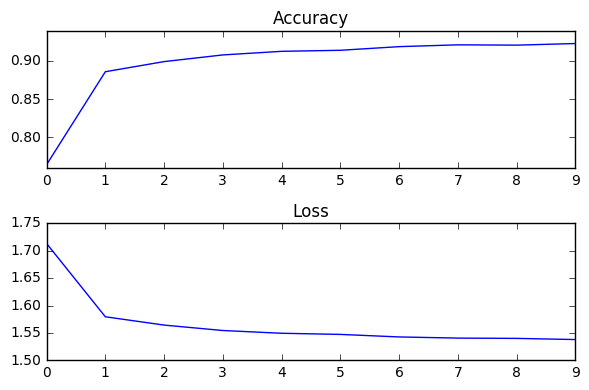

In [11]:
losses = [x[0] for x in history]
accs = [x[1] for x in history]

plt.subplot(211)
plt.title("Accuracy")
plt.plot(accs)

plt.subplot(212)
plt.title("Loss")
plt.plot(losses)

plt.tight_layout()
plt.show()

## Evaluate Model

In [13]:
BEST_MODEL = os.path.join(DATA_DIR, "tf-mnist-fcn-10")
saver = tf.train.Saver()
ys, ys_ = [], []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, BEST_MODEL)
    test_gen = datagen(Xtest, ytest, BATCH_SIZE)
    val_loss, val_acc = 0., 0.
    num_batches = len(Xtrain) // BATCH_SIZE
    for _ in range(num_batches):
        Xbatch, Ybatch = test_gen.next()
        Ybatch_ = sess.run(Y_, feed_dict={X: Xbatch, Y:Ybatch})
        ys.extend(np.argmax(Ybatch, axis=1))
        ys_.extend(np.argmax(Ybatch_, axis=1))

acc = accuracy_score(ys_, ys)
cm = confusion_matrix(ys_, ys)
print("Accuracy: {:.4f}".format(acc))
print("Confusion Matrix")
print(cm)

Accuracy: 0.9199
Confusion Matrix
[[5739    0   89   27   14  146   99   21   67   46]
 [   0 6636   32   28   13   12   18   59   44   31]
 [  19   23 5546  105   47   12   27   89   50    3]
 [  13   34  167 5449    7  116    2   59   92   64]
 [   1    0   37    2 5188   28   28   31   43  153]
 [  14    4    9  204   15 4656   50    8   83   62]
 [  42   21   67    2  119  101 5459    2   71   10]
 [  15   16  106   90   22   42    3 5780   55  147]
 [  26   58  123   99  116  193   49   23 5282  153]
 [   1    3   11   49  341   36    5   87   49 5369]]
